<a href="https://colab.research.google.com/github/donghuna/AI-Expert/blob/main/%ED%99%A9%EC%8A%B9%EC%9B%90/%5BSamsung_AI_Expert_Day3_Lab1%5D_TF_IDF_similarity_search_(Student).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Information Retrieval with TF-IDF

This lab session will guide you through implementing the TF-IDF (Term Frequency-Inverse Document Frequency) weighting scheme from scratch and applying it to analyze question similarity in the Quora Question Pairs dataset.

### Objectives

- Understand and implement TF-IDF.
- Use the TF-IDF vectors to determine the similarity between different questions in the Quora dataset.
- Evaluate the effectiveness of TF-IDF for identifying duplicate questions.

## Understanding and Implementing TF-IDF

#### Introduction to TF-IDF

TF-IDF stands for Term Frequency-Inverse Document Frequency, a commonly used technique in text mining and information retrieval. It reflects how important a word is to a document in a collection or corpus.

#### Step 1: Load the Data

We'll start by loading the Quora Question Pairs dataset. Make sure you have downloaded it from [our google drive](https://drive.google.com/file/d/1BQLCbKrUNTta97xJSdBg1X_G5A82Heng/view?usp=sharing) and placed it in a suitable directory.

In [ ]:
!wget -O train_compact.csv https://drive.google.com/uc?id=1P4zAI3STvY8lZmwvnAJY_4ZU_q03v6Gl

In [ ]:
import pandas as pd

# Load the dataset
data = pd.read_csv('./train_compact.csv')
# Limit the size
M = 3000
N = 2*M
data = data.head(M)
data.head()

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

#### Step 2: Preprocess the Data

We need to preprocess the questions to convert them to a suitable format for TF-IDF calculation. This includes converting text to lowercase, removing punctuation, and tokenizing.

In [ ]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def preprocess(text):
    # Lowercasing
    text = str(text).lower()

    # Remove non-alphanumeric characters
    text = re.sub(r'\W', ' ', text)
    # Tokenization
    tokens = word_tokenize(text)
    # Removing stopwords
    tokens = [word for word in tokens if not word in stop_words]
    return tokens

# Apply preprocessing
data['question1'] = data['question1'].apply(preprocess)
data['question2'] = data['question2'].apply(preprocess)

data.head()

#### Step 3: Calculate Term Frequency (TF)

Term frequency is the ratio of the count of a word present in a sentence, to the length of the sentence.
We apply log frequency weighting as we learned in lecture slides.

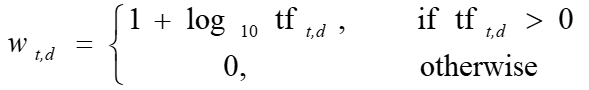

In [ ]:
from math import log10

# Compute tf of each word, make it to dictionary
def compute_tf(tokens):
    # DIY
    # Count frequency of each word
    word_count = {}
    term_freq = {}
    # Your Code Here

    # DIY
    # Log frequency weighting (with base 10)
    # Your Code Here

    return term_freq

data['tf_q1'] = data['question1'].apply(compute_tf)
data['tf_q2'] = data['question2'].apply(compute_tf)
data[['tf_q1', 'tf_q2']].head()

#### Step 4: Calculate Document Frequency (DF) and Inverse Document Frequency (IDF)

Document frequency is the number of documents a word appears in. IDF is calculated as the log of the ratio of total documents to the document frequency, as we covered in lecture slides.

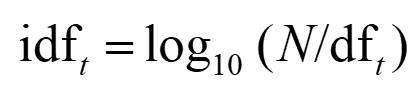

In [ ]:
import numpy as np

# Compute df of each word, make it to dictionary
def compute_document_frequency(series):
    # Create a set of unique words for each document
    word_set = set().union(*series)
    # DIY
    # Calculate document frequency
    df_dict = None # Your Code Here
    return df_dict

def compute_idf(df_dict):
    # DIY
    # Calculate inverse document frequency
    idf_dict = None # Your Code Here
    return idf_dict

# Compute document frequency for all questions
all_questions = pd.concat([data['question1'], data['question2']])
df_dict = compute_document_frequency(all_questions)

# Compute IDF
idf_dict = compute_idf(df_dict)

# Show first five examples
print('IDF Dictionary:')
for i, (word, idf) in enumerate(idf_dict.items()):
    print(f'{word}: {idf}')
    if i > 4:
        break

#### Step 5: Compute TF-IDF Scores

The TF-IDF score is simply the product of TF and IDF.

In [ ]:
def compute_tf_idf(tf_dict, idf_dict):
    tf_idf_dict = {}
    # DIY
    # Your Code Here
    return tf_idf_dict

# Show TF-IDF values
data['tf_idf_q1'] = data['tf_q1'].apply(compute_tf_idf, args=(idf_dict,))
data['tf_idf_q2'] = data['tf_q2'].apply(compute_tf_idf, args=(idf_dict,))
data[['tf_idf_q1', 'tf_idf_q2']].head()

### Applying TF-IDF to Question Similarity

#### Step 6: Calculate Cosine Similarity

We will now calculate the cosine similarity between question pairs to find out how similar they are.

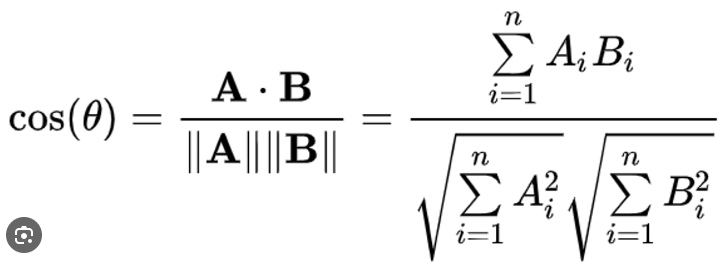

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Convert TF-IDF dictionaries to vectors for comparison
def tf_idf_to_vector(tf_idf_dict, idf_index):
    return np.array([tf_idf_dict.get(word, 0) for word in idf_index])

idf_index = list(idf_dict.keys())
vectors_q1 = data['tf_idf_q1'].apply(lambda x: tf_idf_to_vector(x, idf_index))
vectors_q2 = data['tf_idf_q2'].apply(lambda x: tf_idf_to_vector(x, idf_index))

# Calculate cosine similarity
data['cosine_similarity'] = [
    cosine_similarity([v1], [v2])[0][0] for v1, v2 in zip(vectors_q1, vectors_q2)
]
data[['cosine_similarity']].head()

,cosine_similarity
0,0.978264
1,0.727736
2,0.261185
3,0.000000
4,0.224548


In [ ]:
# Show Document-Term Matrix for TF-IDF (q1)
# Row represents word (str), column represents document (q1)
DTM_tp = pd.DataFrame(vectors_q1.values.tolist(), columns=idf_index)
DTM = DTM_tp.transpose()
DTM.head()

In [ ]:
# Show the rows of DTM where column 0 is non-zero
DTM[DTM.iloc[:, 0] != 0]

#### Step 7: Evaluate the Model

Finally, we evaluate how well our TF-IDF based similarity measurement correlates with the duplicate labels in the dataset.

In [ ]:
# Assume a threshold to determine duplicates
threshold = 0.6
data['predicted_duplicate'] = data['cosine_similarity'] > threshold
true_labels = data['is_duplicate']

# Calculate Accuracy
accuracy = (data['predicted_duplicate'] == true_labels).mean()
print('Accuracy:', accuracy)

In [ ]:
# See if the distribution of cosine similarity differs at each case
# Draw boxplot
import matplotlib.pyplot as plt
import seaborn as sns

sns.boxplot(x='is_duplicate', y='cosine_similarity', data=data)
plt.show()

### Applying TF-IDF for Retrieval

#### Step 8: Retrieve Questions with Highest Cosine Similarity

Now that we have seen that cosine similarity among TF-IDF vectors indicates semantic similarity, we now apply it for retrieval. The code below shows how to retrieve similar questions for a specific target question.

In [ ]:
# Retrieve similar questions for the given query
# Use TF-IDF vectors and cosine similarity

# Load the dataset
data_raw = pd.read_csv('./train_compact.csv')
data_raw = data_raw.head(M)

<ipython-input-41-825790177918>:5: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  data_raw = pd.read_csv('./train_compact.csv')


In [ ]:
data_raw.head()

In [ ]:
target_query_id = 0
target_query = data_raw.iloc[target_query_id]['question1']
target_query

'What is the step by step guide to invest in share market in india?'

In [ ]:
# Find top-5 questions that is similar to target_query
# Use cosine similarity

target_vector = vectors_q1[target_query_id].reshape(1, -1)
# integrate vectors_q1 and vectors_q2
vectors_integ = np.concatenate([vectors_q1, vectors_q2], axis=0)
# make array from vectors_q1
_vectors_integ = np.array([vectors_integ[query_id] for query_id in range(len(vectors_integ))])

print(target_vector.shape)
print(_vectors_integ.shape)
similarities = cosine_similarity(target_vector, _vectors_integ)
top_indices = similarities.argsort()[0][-5:][::-1]

In [ ]:
# Show the questions with top similarities
for i, idx in enumerate(top_indices):
    if idx < M:
      print(f'Question {i+1} ({similarities[0][idx]}): {data_raw.iloc[idx]["question1"]}')
    else:
      print(f'Question {i+1} ({similarities[0][idx]}): {data_raw.iloc[idx-M]["question2"]}')